In [ ]:
pip install segmentation_models

     |████████████████████████████████| 51kB 3.4MB/s 


In [ ]:
import tensorflow as tf

In [ ]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [ ]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [ ]:
import segmentation_models as sm
from segmentation_models import PSPNet, Linknet, FPN
from segmentation_models import get_preprocessing
from segmentation_models.losses import jaccard_loss,dice_loss
from segmentation_models.metrics import iou_score, precision
import glob
import os
import cv2
import numpy as np
import h5py
import tensorflow as tf
from PIL import Image
import random
import matplotlib.pyplot as plt

Segmentation Models: using `tf.keras` framework.


In [ ]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
SIZE = 256
train_images = []
train_masks = []

In [ ]:
for directory_path in glob.glob("/content/drive/MyDrive/Papsynth/dataset/Augmented/Image"):
    for img_path in glob.glob(os.path.join(directory_path, "*.tif")):
        #print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE, SIZE))
        #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        #train_labels.append(label)
#Convert list to array for machine learning processing        
train_images = np.array(train_images)

In [ ]:
print(len(train_images))

300


In [ ]:
for directory_path in glob.glob("/content/drive/MyDrive/Papsynth/dataset/Augmented/Mask"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.tif")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE, SIZE))
        #mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
        train_masks.append(mask)
        #train_labels.append(label)
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks).astype(np.float32)

In [ ]:
print(train_masks.shape)

(300, 256, 256)


In [ ]:
X = train_images
Y = train_masks
#Y = np.expand_dims(Y, axis=3)

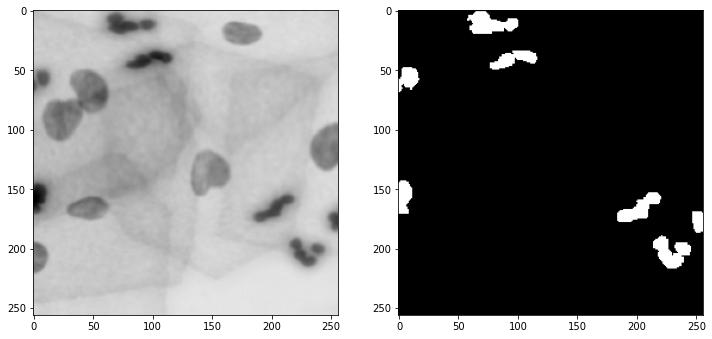

In [ ]:
image_number = random.randint(0, len(X))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X[image_number], cmap='gray')
plt.subplot(122)
plt.imshow(Y[image_number], cmap='gray')
plt.show()

In [ ]:
print(image_number)

149


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.1, random_state=42)

In [ ]:
# preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

In [ ]:
model = sm.Linknet(BACKBONE, input_shape=(SIZE, SIZE, 3),classes=1, encoder_weights='imagenet')
model.compile('Adam', loss=[jaccard_loss,dice_loss], metrics=[iou_score, precision])

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_34 (ZeroPadding2 (None, 262, 262, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64) 9408        zero_padding2d_34[0][0]          
____________________________________________________________________________________________

In [ ]:
history=model.fit(x_train, 
          y_train,
          batch_size=10, 
          epochs=20,
          verbose=1,
          validation_data=(x_val, y_val))

Epoch 1/20
27/27 [==============================] - 266s 10s/step - loss: 0.8940 - iou_score: 0.1060 - precision: 0.1064 - val_loss: 0.9041 - val_iou_score: 0.0959 - val_precision: 0.1140
Epoch 2/20
27/27 [==============================] - 265s 10s/step - loss: 0.6739 - iou_score: 0.3261 - precision: 0.3314 - val_loss: 0.8858 - val_iou_score: 0.1142 - val_precision: 0.1150
Epoch 3/20
27/27 [==============================] - 261s 10s/step - loss: 0.2955 - iou_score: 0.7045 - precision: 0.7463 - val_loss: 0.7325 - val_iou_score: 0.2675 - val_precision: 0.2822
Epoch 4/20
27/27 [==============================] - 259s 10s/step - loss: 0.1875 - iou_score: 0.8125 - precision: 0.8715 - val_loss: 0.9393 - val_iou_score: 0.0607 - val_precision: 0.0612
Epoch 5/20
27/27 [==============================] - 259s 10s/step - loss: 0.1734 - iou_score: 0.8266 - precision: 0.8901 - val_loss: 0.3970 - val_iou_score: 0.6030 - val_precision: 0.6862
Epoch 6/20
27/27 [==============================] - 261s 10s

In [ ]:
accuracy = model.evaluate(x_val, y_val)

1/1 [==============================] - 7s 7s/step - loss: 0.1675 - iou_score: 0.8325 - precision: 0.9402


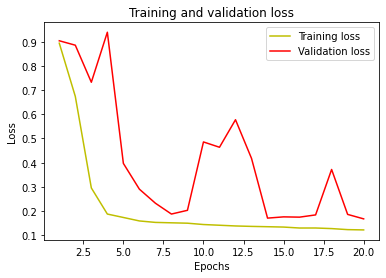

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Papsynth/linknet_pap.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/Papsynth/linknet_pap.h5', compile=False)

In [ ]:
test_img = cv2.imread('/content/drive/MyDrive/Papsynth/dataset/test/img_41_01_01.png', cv2.IMREAD_COLOR)       
test_img = cv2.resize(test_img, (SIZE, SIZE))
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
test_img = np.expand_dims(test_img, axis=0)

In [ ]:
prediction = model.predict(test_img)
prediction_image = prediction.reshape(mask.shape)

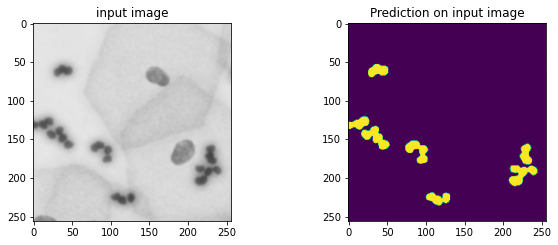

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('input image')
plt.imshow(np.squeeze(test_img), cmap='gray')
#plt.subplot(232)
#plt.title('Ground truth')
#img = cv2.imread('C:/Users/sudee/Desktop/New folder (5)/noise/aug/msk/20.tif')
#img = cv2.resize(img, (SIZE, SIZE))
#plt.imshow(img)
plt.subplot(232)
plt.title('Prediction on input image')
plt.imshow(prediction_image)
plt.show()